In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

## Reading the data

In [2]:
# Read the CSV file into a DataFrame
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
data['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

### Splitting the data

In [7]:
X = data.drop('DEATH_EVENT' , axis = 1)
y = data.DEATH_EVENT

### Oversampling the data

In [8]:
sm = SMOTE()
X,y = sm.fit_resample(X,y)

### Scaling the features

In [9]:
# Creating function for scaling
def Standard_Scaler (data, col_names):
    features = data[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    data[col_names] = features
    
    return data

In [10]:
X = Standard_Scaler(X , X.columns)

## Test train split VS Cross validation

In [11]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.25 , random_state = 42 , shuffle = True)

In [12]:
rfc = RandomForestClassifier(n_estimators=50, random_state=13)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [13]:
def evaluate_normal_model(pred , test):
    recall = recall_score(test, pred)
    precision = precision_score(test, pred)
    f1 = f1_score(test, pred)
    accuracy = accuracy_score(test, pred)
    cm = confusion_matrix(test, pred)
    
    return recall, precision, f1, accuracy, cm

def evaluate_cv_model(model, X_train, y_train, kFolds):
    r_score = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='recall')
    recall = r_score.mean()
    p_score = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='precision')
    precision = p_score.mean()
    f1_score = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='f1')
    f1 = f1_score.mean()
    a_score = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='accuracy')
    accuracy = a_score.mean()

    return recall, precision, f1, accuracy

In [14]:
kf = KFold(n_splits=5, random_state=42 , shuffle = True)

In [15]:
n_recall, n_precision, n_f1, n_accuracy, n_cm = evaluate_normal_model(y_pred , y_test)

In [16]:
cv_recall, cv_precision, cv_f1, cv_accuracy = evaluate_cv_model(rfc, X_train, y_train, kf)

In [17]:
dataFrame = [(n_recall, cv_recall, n_precision, cv_precision, n_f1, cv_f1, n_accuracy, cv_accuracy)]
rfc_score = pd.DataFrame(data = dataFrame, columns=
                        ['N-Recall', 'CV-Recall', 'N-Precision', 'CV-Precision', 
                         'N-F1 Score', 'CV-F1 Score','N-Accuracy','CV-Accuracy'])
rfc_score.insert(0, 'Random Forest', 'Before Grid Search')
rfc_score

,Random Forest,N-Recall,CV-Recall,N-Precision,CV-Precision,N-F1 Score,CV-F1 Score,N-Accuracy,CV-Accuracy
0,Before Grid Search,0.843137,0.910635,0.86,0.885953,0.851485,0.896639,0.852941,0.894372


### Confusion Matrix before Grid Search

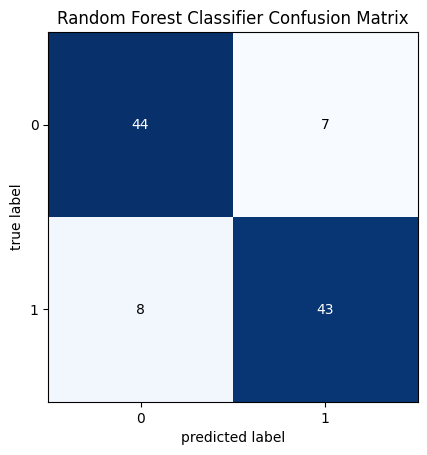

In [18]:
plot_confusion_matrix(n_cm)
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

## Using Grid Search to optimize the model

In [19]:
params = {
    "max_depth": [5,9,10,12,15,20],
    "min_samples_leaf": [1,2,3],
    'n_estimators': [25,50,100,130,170,190,200],
    'random_state': [13,42],
    'min_samples_split': [3,4,5,6]
}

In [20]:
grid = GridSearchCV(rfc , param_grid=params, cv=kf, scoring='accuracy').fit(X_train, y_train)

In [21]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50,
 'random_state': 13}

In [22]:
grid_rfc = RandomForestClassifier(n_estimators=100, random_state=13 , min_samples_leaf=1, min_samples_split=3, max_depth=9)
grid_rfc.fit(X_train, y_train)
y_pred_grid = grid_rfc.predict(X_test)

In [23]:
grid_n_recall, grid_n_precision, grid_n_f1, grid_n_accuracy, grid_n_cm = evaluate_normal_model(y_pred_grid , y_test)

In [24]:
grid_cv_recall, grid_cv_precision, grid_cv_f1, grid_cv_accuracy = evaluate_cv_model(grid_rfc, X_train, y_train, kf)

In [25]:
dataFrame = [(grid_n_recall, grid_cv_recall, grid_n_precision, grid_cv_precision, grid_n_f1, grid_cv_f1, grid_n_accuracy, grid_cv_accuracy)]
grid_rfc_score = pd.DataFrame(data = dataFrame, columns =
                        ['N-Recall', 'CV-Recall', 'N-Precision', 'CV-Precision',
                         'N-F1 Score', 'CV-F1 Score','N-Accuracy','CV-Accuracy'])
grid_rfc_score.insert(0, 'Random Forest', 'After Grid Search')
grid_rfc_score

,Random Forest,N-Recall,CV-Recall,N-Precision,CV-Precision,N-F1 Score,CV-F1 Score,N-Accuracy,CV-Accuracy
0,After Grid Search,0.862745,0.924292,0.862745,0.889408,0.862745,0.904572,0.862745,0.901093


### Confusion Matrix after Grid Search

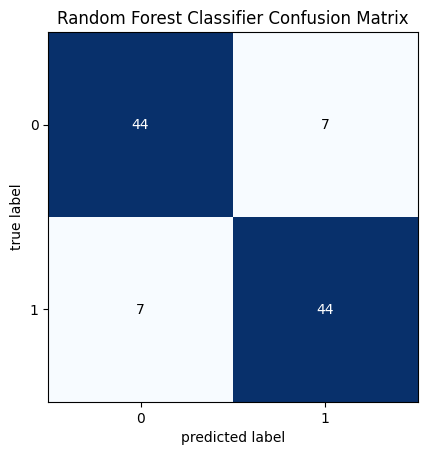

In [26]:
plot_confusion_matrix(grid_n_cm)
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

## Showing the most important features

In [28]:
imp_features = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": grid.best_estimator_.feature_importances_
})

imp_features.sort_values(by="Imp", ascending=False)

,Varname,Imp
11,time,0.368444
7,serum_creatinine,0.196874
4,ejection_fraction,0.100893
8,serum_sodium,0.080192
0,age,0.079743
2,creatinine_phosphokinase,0.067509
6,platelets,0.056583
9,sex,0.015610
10,smoking,0.010145
5,high_blood_pressure,0.008734


## Before Grid Search Scores VS After Grid Search Scores

In [29]:
predictions = pd.concat([rfc_score, grid_rfc_score], ignore_index=True, sort=False)
predictions.sort_values(by=['CV-Recall'], ascending=False)

,Random Forest,N-Recall,CV-Recall,N-Precision,CV-Precision,N-F1 Score,CV-F1 Score,N-Accuracy,CV-Accuracy
1,After Grid Search,0.862745,0.924292,0.862745,0.889408,0.862745,0.904572,0.862745,0.901093
0,Before Grid Search,0.843137,0.910635,0.860000,0.885953,0.851485,0.896639,0.852941,0.894372
